In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import robust_scale
import matplotlib.pyplot as plt
from umap import UMAP
from hdbscan import HDBSCAN
import matplotlib.colors as colors

sns.set_theme(context="notebook", style="darkgrid")
random_state = 42

Load data

In [64]:
data = pd.read_csv(
    filepath_or_buffer="data\\marketing_campaign.csv", 
    sep="\t", 
    parse_dates=["Dt_Customer"]
)

data = data.fillna(0)

### Replace values: 
- Maritial Status to four categories
- Combine "kids" and "teens" columns
- Convert Costumer age to integer
- Clip unrealistic values for year born and income

In [65]:
data.set_index("ID", inplace=True)
data.replace(
    to_replace={
        "YOLO": "Single",
        "Absurd": "Single",
        "Alone": "Single",
        "Together": "Married"},
        inplace=True
)

data.Kidhome += data["Teenhome"]
data.drop(["Teenhome", "Z_CostContact", "Z_Revenue"], axis=1, inplace=True)
# data.drop(", axis=1, inplace=True)
data.Income = np.clip(data.Income, 10_000, 150_000)
data.Year_Birth = np.clip(data.Year_Birth, 1940, 2020)
data_original = data.copy()
data.Dt_Customer = data["Dt_Customer"].view("int64")

Calculate total amount of money spent

In [66]:
money_spent_total = (
    data["MntWines"] +
    data["MntFruits"] +
    data["MntMeatProducts"] + 
    data["MntFishProducts"] + 
    data["MntSweetProducts"] + 
    data["MntGoldProds"]
)

Encode categorical features

In [67]:
Education_categories = ["Basic", "Graduation", "2n Cycle", "Master", "PhD"]

ordinal_enc = OrdinalEncoder(
    categories=[Education_categories],
    dtype="int"
)

oh_enc = OneHotEncoder(
    sparse=False,
    dtype="int"
)

education_ordinal = pd.DataFrame(ordinal_enc.fit_transform(
    X=np.array(data.Education).reshape(-1, 1))).set_index(data.index)

Marital_Status_binary = pd.DataFrame(oh_enc.fit_transform(
    X=np.array(data["Marital_Status"]).reshape(-1, 1)), columns=data.Marital_Status.unique()).set_index(data.index)

data = pd.concat([data, education_ordinal, Marital_Status_binary], axis=1)
data = data.drop(labels=["Education", "Marital_Status"], axis=1)
data_columns = data.columns
data = robust_scale(data)

EDA

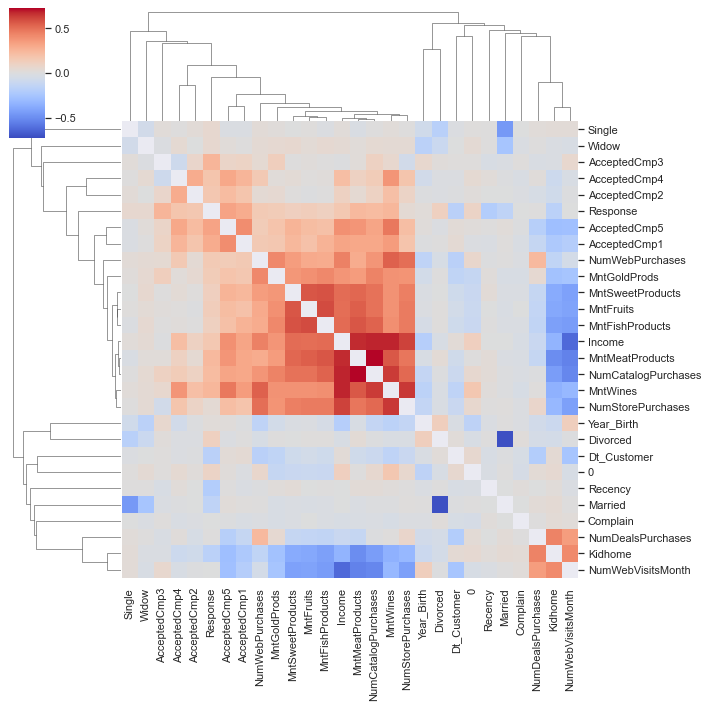

In [68]:
mask=np.identity(len(data_columns))
sns.clustermap(
    pd.DataFrame(robust_scale(data), columns=data_columns).corr(),
    metric="cosine",
    mask=mask,
    cmap="coolwarm",
    # z_score=1,
    norm=colors.CenteredNorm())

### Main takeaways
- Number of Kids and number of Web Visits correlate negative with income and money spend
- Income correlates very strong positive with number of purchases and money spent on products (all categories)

### Clustering
Map to two dimensions

In [69]:
reducer = UMAP(
    n_components=4,
    min_dist=0,
    n_neighbors=30,
    densmap=True,
    metric="cosine",
    target_metric="l2",
    unique=True,
    random_state=random_state
)

embedding = reducer.fit_transform(
    X=data,
    # y=robust_scale(money_spent_total)
)

Plot data

<AxesSubplot:>

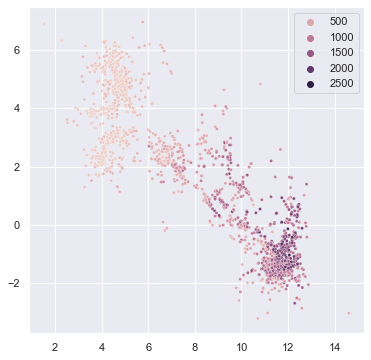

In [70]:
plt.figure(figsize=(6,6))

sns.scatterplot(
    x=embedding[:,0],
    y=embedding[:,1],
    s=10,
    hue=money_spent_total,
)

Unsupervised clustering

In [71]:
clusterer = HDBSCAN(
    min_cluster_size=100,
    min_samples=10,
    # metric="correlation"
)

clusters = clusterer.fit_predict(embedding)

Plot detected clusters

<AxesSubplot:>

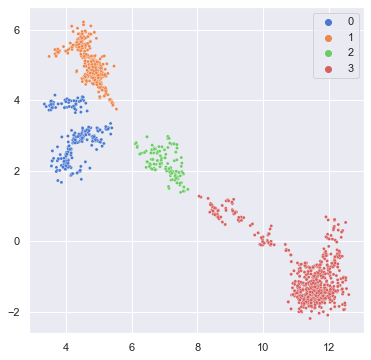

In [72]:
plt.figure(figsize=(6,6))
sns.scatterplot(
    x=embedding[:,0][clusters!=-1],
    y=embedding[:,1][clusters!=-1],
    alpha="auto",
    s=10,
    hue=clusters[clusters!=-1],
    palette="muted",
    # color="gray"
)

EDA

In [ ]:
data.G

<AxesSubplot:ylabel='Density'>

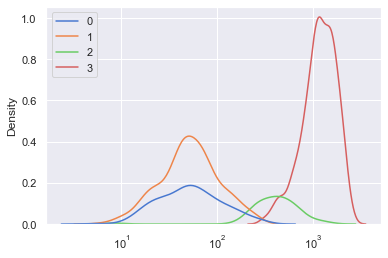

In [85]:
sns.kdeplot(
    data=data_original[clusters!=-1],
    x=money_spent_total[clusters!=-1],
    hue=clusters[clusters!=-1],
    # multiple="stack",
    palette="muted",
    log_scale=True
)

<AxesSubplot:xlabel='Income', ylabel='Density'>

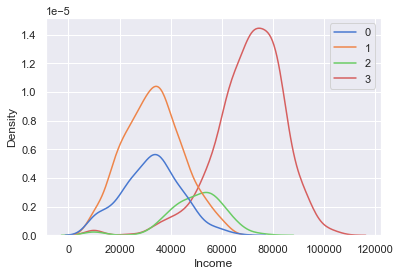

In [74]:
sns.kdeplot(
    x=data_original[clusters!=-1].Income+1,
    # x="Income",
    hue=clusters[clusters!=-1],
    # multiple="fill",
    palette="muted",
)

<AxesSubplot:xlabel='Kidhome', ylabel='Count'>

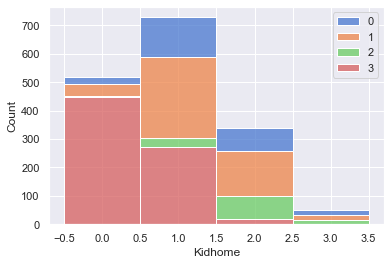

In [75]:
sns.histplot(
    data=data_original[clusters!=-1],
    x="Kidhome",
    hue=clusters[clusters!=-1],
    multiple="stack",
    palette="muted",
    bins=50,
    element="bars",
    discrete=True,
    # kde=True,
    # log_scale=True
)

<AxesSubplot:xlabel='Education', ylabel='Count'>

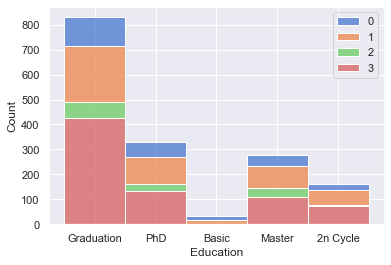

In [76]:
sns.histplot(
    data=data_original[clusters!=-1],
    x="Education",
    hue=clusters[clusters!=-1],
    multiple="stack",
    palette="muted",
    bins=50,
    element="bars",
    discrete=True,
    # kde=True,
    # log_scale=True
)

<AxesSubplot:xlabel='Response', ylabel='Count'>

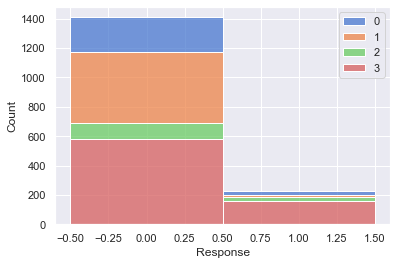

In [77]:
sns.histplot(
    data=data_original[clusters!=-1],
    x="Response",
    hue=clusters[clusters!=-1],
    multiple="stack",
    palette="muted",
    bins=50,
    element="bars",
    discrete=True,
    # kde=True,
    # log_scale=True
)

[Text(0.5, 0, 'Customer since')]

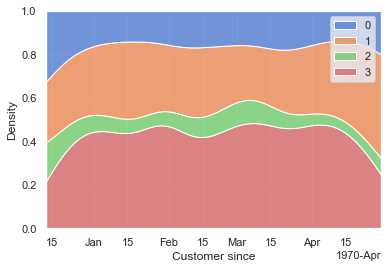

In [82]:
import matplotlib.dates as mdates

plot = sns.kdeplot(
    x=data_original[clusters!=-1].Recency,
    hue=clusters[clusters!=-1],
    multiple="fill",
    palette="muted",
)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

plot.xaxis.set_major_locator(locator)
plot.xaxis.set_major_formatter(formatter)
plot.set(xlabel="Customer since")